In [106]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
#import spacy
import re
import string
import numpy as np

from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('imdb/IMDB Dataset.csv')
df['Label'] = 0

In [4]:
df.loc[df.sentiment == 'positive','Label'] = 1
df

,review,sentiment,Label
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. <br /><br />The...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1
...,...,...,...
49995,I thought this movie did a down right good job...,positive,1
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,0
49997,I am a Catholic taught in parochial elementary...,negative,0
49998,I'm going to have to disagree with the previou...,negative,0


In [5]:
STOPWORDS = set.union(set(stopwords.words('english')),set(string.punctuation),set(['...','']))
WL = WordNetLemmatizer()

In [6]:
def clean_txt(text):
    text = text.lower()
    text =  re.sub(r'<\w+ />','',text)
    text  = re.sub(r"[^a-zA-Z0-9]+", ' ', text)
    #text = re.sub(r'\d+(th)?',' ',text) #remove all the numbers
    text = re.sub(r'\d+(th)?','number',text) #remove all the numbers
    return text
    
  
    
def tokenize_clean(text):
    tokens = nltk.word_tokenize(text)
    tokens = [token for token in tokens if token not in STOPWORDS]
    return tokens

def lemmatize(tokens): 
    return [WL.lemmatize(word) for word in tokens]
    
df['cleaned'] = df.review.progress_apply(lambda r: clean_txt(r))
df['tokenized'] = df.cleaned.progress_apply(lambda r: tokenize_clean(r))
df['lemmatized'] = df.tokenized.progress_apply(lambda r: lemmatize(r))

progress-bar: 100%|██████████| 50000/50000 [00:30<00:00, 1654.49it/s]


In [ ]:
### wordlcoud

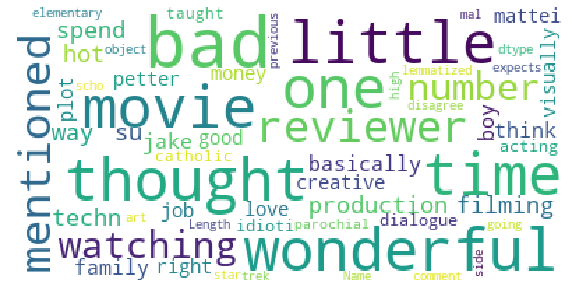

In [101]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
wordcloud = WordCloud(
                          background_color='white',
                          #stopwords=stop_words,
                          max_words=100,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(df['lemmatized']))
fig = plt.figure(1,figsize=(10,7))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
#fig.savefig("word1.png", dpi=900)

### Vectorization

In [102]:
tfidf = TfidfVectorizer(
    analyzer='word',
    tokenizer=lambda r: r,
    preprocessor=lambda r: r,
    token_pattern=None,
    max_features=10000) 

#tfidf.fit(tokenized)

In [8]:
TFIDF = np.asarray(tfidf.fit_transform(df.lemmatized,).todense())
TFIDF

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [9]:
Labels = df.Label.to_numpy()


In [10]:
print(tfidf.get_feature_names()[:100])
print(TFIDF.shape)

['aaron', 'abandon', 'abandoned', 'abbey', 'abbott', 'abc', 'abducted', 'ability', 'able', 'ably', 'aboard', 'abominable', 'abomination', 'abortion', 'abound', 'abraham', 'abroad', 'abrupt', 'abruptly', 'absence', 'absent', 'absolute', 'absolutely', 'absorbed', 'absorbing', 'abstract', 'absurd', 'absurdity', 'abundance', 'abuse', 'abused', 'abusive', 'abysmal', 'abyss', 'academic', 'academy', 'accent', 'accept', 'acceptable', 'acceptance', 'accepted', 'accepting', 'accepts', 'access', 'accessible', 'accident', 'accidental', 'accidentally', 'acclaim', 'acclaimed', 'accolade', 'accompanied', 'accompanies', 'accompany', 'accompanying', 'accomplice', 'accomplish', 'accomplished', 'accomplishment', 'according', 'accordingly', 'account', 'accuracy', 'accurate', 'accurately', 'accusation', 'accused', 'accustomed', 'ace', 'achieve', 'achieved', 'achievement', 'achieves', 'achieving', 'acid', 'acknowledge', 'acknowledged', 'acquaintance', 'acquired', 'across', 'act', 'acted', 'acting', 'action'

In [11]:
X_train, X_test, y_train, y_test = train_test_split(TFIDF, Labels, test_size=0.2, random_state=42)

### Logistic Regression

In [13]:
clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(X_train, y_train)
ypred_train = clf.predict(X_train)
#clf.predict_proba(X_train) 


/Users/Tinmar/anaconda3/envs/nlp/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [14]:
ypred_test = clf.predict(X_test)
print(classification_report(y_test, ypred_test))

              precision    recall  f1-score   support

           0       0.91      0.88      0.89      4961
           1       0.89      0.91      0.90      5039

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



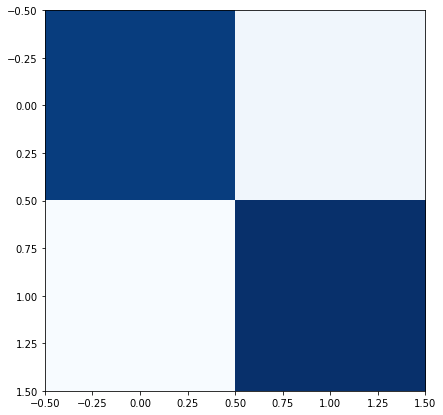

In [15]:
fig,ax = plt.subplots(figsize=(7,7))
cm = confusion_matrix(y_test, ypred_test)
plt.imshow(cm.astype('float')/cm.sum(),cmap = plt.cm.Blues)

### SVM

In [16]:
clf = LinearSVC(random_state=0, tol=1e-5)
#clf = SVC(gamma='auto')
clf_trained = clf.fit(X_train, y_train)

In [17]:
ypred_train = clf_trained.predict(X_train)

In [18]:
ypred_test = clf.predict(X_test)
print(classification_report(y_test, ypred_test))

              precision    recall  f1-score   support

           0       0.89      0.88      0.88      4961
           1       0.88      0.89      0.89      5039

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



### Using Shallow NN in keras

In [68]:
import tensorflow as tf
import keras

from keras.models import Sequential
from keras.layers import Dense
from keras.regularizers import l2
from keras.wrappers.scikit_learn import KerasClassifier


In [69]:
L2reg = 0.001
model = Sequential([
                  Dense(300, activation='relu', input_shape=(10000,)),
                  Dense(64, activation='relu',activity_regularizer=l2(L2reg)),
                  Dense(1, activation='sigmoid',activity_regularizer=l2(L2reg))
                ])

In [70]:
model.compile(
  optimizer='adam',
  loss='binary_crossentropy',
  metrics=['accuracy'],
)

In [71]:
model.fit(
  X_train, # training data
  y_train, # training targets
  epochs=5,
  batch_size=32,
)

Epoch 1/5
40000/40000 [==============================] - 54s 1ms/step - loss: 0.3576 - accuracy: 0.8712
Epoch 2/5
40000/40000 [==============================] - 56s 1ms/step - loss: 0.1916 - accuracy: 0.9432
Epoch 3/5
40000/40000 [==============================] - 66s 2ms/step - loss: 0.0720 - accuracy: 0.9906
Epoch 4/5
40000/40000 [==============================] - 57s 1ms/step - loss: 0.0389 - accuracy: 0.9997
Epoch 5/5
40000/40000 [==============================] - 62s 2ms/step - loss: 0.0313 - accuracy: 1.0000


In [94]:
preds = model.predict_classes(X_test)
preds = preds.flatten()
preds

array([0, 1, 0, ..., 1, 0, 1], dtype=int32)

In [95]:
#preds[preds <= 0.5] = 0
#preds[preds > 0.5] = 1
#preds

In [97]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89      4961
           1       0.89      0.89      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

